# 1. 품사 태깅 데이터

In [10]:
# 토큰화에 품사 태킹된 데이터 받아오기
import nltk

tagged_sents = nltk.corpus.treebank.tagged_sents()
print("size of sentences by tagged : ",len(tagged_sents))

size of sentences by tagged :  3914


In [11]:
print(tagged_sents[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [12]:
# 단어 부분과 품사 태깅 정보를 따로 저장.

sents, pos_tags = [],[]

for tagged_sent in tagged_sents :
    
    sent , pos_tag = zip(*tagged_sent)

    sents.append(list(sent))
    tags.append(list(pos_tag))
    
print(sents[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


max length of samples :  271
mean length of samples : 25.722023505365357


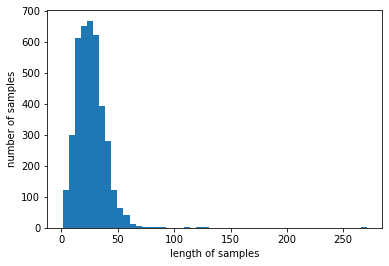

In [17]:
import matplotlib.pyplot as plt

maxlen = max(len(sent) for sent in sents)
meanlen = (sum(map(len,sents)) / len(sents))

print("max length of samples : ",maxlen)
print("mean length of samples :",meanlen)


plt.hist([len(sent) for sent in sents],bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(sample) :
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sample)
    return tokenizer


sent_tokenizer = tokenize(sents)
tag_tokenizer = tokenize(pos_tags)

In [19]:
vocab_size = len(sent_tokenizer.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1

print("vocabulary size : ",vocab_size)
print("tag size : ",tag_size)

vocabulary size :  11388
tag size :  47


In [21]:
# 정수 인코딩 & 패딩(size : 150)

from tensorflow.keras.preprocessing.sequence import pad_sequences

X = sent_tokenizer.texts_to_sequences(sents)
y = tag_tokenizer.texts_to_sequences(tags)

max_len = 150
X = pad_sequences(X,maxlen=max_len)
y = pad_sequences(y,maxlen=max_len)

In [23]:
# 8:2 비율로 train-test split
# random_state 는 책과 동일하게 진행

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=0.2, random_state=777)

In [25]:
# 태깅 정보에 대해서 원-핫 인코딩 수행

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=tag_size)
y_test = to_categorical(y_test,num_classes=tag_size)

In [28]:
# 각 데이터 크기

print("train sentences size : ",X_train.shape)
print("train tag size :",y_train.shape)
print("test sentences size : ",X_test.shape)
print("test tag size :",y_test.shape)

train sentences size :  (3131, 150)
train tag size : (3131, 150, 47)
test sentences size :  (783, 150)
test tag size : (783, 150, 47)


# 양방향 LSTM 으로 Pos Tagger 만들기

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, TimeDistributed

model = Sequential()
model.add(Embedding(vocab_size,128,input_length=max_len,mask_zero=True))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size,activation='softmax')))

In [31]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,batch_size=128,
          epochs=6,validation_data=(X_test,y_test))

Epoch 1/6
25/25 [==============================] - 52s 2s/step - loss: 0.6161 - acc: 0.1251 - val_loss: 0.5069 - val_acc: 0.1615
Epoch 2/6
25/25 [==============================] - 46s 2s/step - loss: 0.4983 - acc: 0.1902 - val_loss: 0.4619 - val_acc: 0.3489
Epoch 3/6
25/25 [==============================] - 46s 2s/step - loss: 0.4384 - acc: 0.3942 - val_loss: 0.3301 - val_acc: 0.5083
Epoch 4/6
25/25 [==============================] - 46s 2s/step - loss: 0.2958 - acc: 0.5592 - val_loss: 0.1988 - val_acc: 0.7257
Epoch 5/6
25/25 [==============================] - 46s 2s/step - loss: 0.1695 - acc: 0.7765 - val_loss: 0.1116 - val_acc: 0.8594
Epoch 6/6
25/25 [==============================] - 46s 2s/step - loss: 0.0868 - acc: 0.8970 - val_loss: 0.0743 - val_acc: 0.8996


In [32]:
print("accuracy : ",model.evaluate(X_test,y_test)[1])

25/25 [==============================] - 6s 242ms/step - loss: 0.0743 - acc: 0.8996
accuracy :  0.8996108174324036


In [43]:
import numpy as np

index_to_word=sent_tokenizer.index_word
index_to_tag=tag_tokenizer.index_word

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_pred = model.predict(np.array([X_test[10]])) 

# 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
y_pred = np.argmax(y_pred, axis=-1) 
y_true = np.argmax(y_test[10], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[10], y_true, y_pred[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), 
                                      index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
